## Inference

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import json

In [3]:
# Copyright (c) Guangsheng Bao.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import time
import os

def from_pretrained(cls, model_name, kwargs, cache_dir):
    # use local model if it exists
    local_path = os.path.join(cache_dir, 'local.' + model_name.replace("/", "_"))
    if os.path.exists(local_path):
        return cls.from_pretrained(local_path, **kwargs)
    return cls.from_pretrained(model_name, **kwargs, cache_dir=cache_dir)

# predefined models
model_fullnames = {  'kogpt2-base':'skt/kogpt2-base-v2',
                     'gpt2': 'gpt2',
                     'gpt2-xl': 'gpt2-xl',
                     'opt-2.7b': 'facebook/opt-2.7b',
                     'gpt-neo-2.7B': 'EleutherAI/gpt-neo-2.7B',
                     'gpt-j-6B': 'EleutherAI/gpt-j-6B',
                     'gpt-neox-20b': 'EleutherAI/gpt-neox-20b',
                     'mgpt': 'sberbank-ai/mGPT',
                     'pubmedgpt': 'stanford-crfm/pubmedgpt',
                     'mt5-xl': 'google/mt5-xl',
                     'llama-13b': 'huggyllama/llama-13b',
                     'llama2-13b': 'TheBloke/Llama-2-13B-fp16',
                     'bloom-7b1': 'bigscience/bloom-7b1',
                     'opt-13b': 'facebook/opt-13b',
                     }
float16_models = ['gpt-j-6B', 'gpt-neox-20b', 'llama-13b', 'llama2-13b', 'bloom-7b1', 'opt-13b']

def get_model_fullname(model_name):
    return model_fullnames[model_name] if model_name in model_fullnames else model_name

def load_model(model_name, device, cache_dir):
    model_fullname = get_model_fullname(model_name)
    print(f'Loading model {model_fullname}...')
    model_kwargs = {}
    if model_name in float16_models:
        model_kwargs.update(dict(torch_dtype=torch.float16))
    if 'gpt-j' in model_name:
        model_kwargs.update(dict(revision='float16'))
    model = from_pretrained(AutoModelForCausalLM, model_fullname, model_kwargs, cache_dir)
    print('Moving model to GPU...', end='', flush=True)
    start = time.time()
    model.to(device)
    print(f'DONE ({time.time() - start:.2f}s)')
    return model

def load_tokenizer(model_name, for_dataset, cache_dir):
    model_fullname = get_model_fullname(model_name)
    optional_tok_kwargs = {}
    if "facebook/opt-" in model_fullname:
        print("Using non-fast tokenizer for OPT")
        optional_tok_kwargs['fast'] = False
    if for_dataset in ['pubmed']:
        optional_tok_kwargs['padding_side'] = 'left'
    else:
        optional_tok_kwargs['padding_side'] = 'right'
    base_tokenizer = from_pretrained(AutoTokenizer, model_fullname, optional_tok_kwargs, cache_dir=cache_dir)
    if base_tokenizer.pad_token_id is None:
        base_tokenizer.pad_token_id = base_tokenizer.eos_token_id
        if '13b' in model_fullname:
            base_tokenizer.pad_token_id = 0
    return base_tokenizer

In [4]:
# Copyright (c) Guangsheng Bao.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# 15 colorblind-friendly colors
COLORS = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442",
            "#56B4E9", "#E69F00", "#000000", "#0072B2", "#009E73",
            "#D55E00", "#CC79A7", "#F0E442", "#56B4E9", "#E69F00"]


def get_roc_metrics(real_preds, sample_preds):
    fpr, tpr, _ = roc_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    roc_auc = auc(fpr, tpr)
    return fpr.tolist(), tpr.tolist(), float(roc_auc)


def get_precision_recall_metrics(real_preds, sample_preds):
    precision, recall, _ = precision_recall_curve([0] * len(real_preds) + [1] * len(sample_preds),
                                                  real_preds + sample_preds)
    pr_auc = auc(recall, precision)
    return precision.tolist(), recall.tolist(), float(pr_auc)


```
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset_file', type=str, default="./high2_data.json")
    parser.add_argument('--reference_model_name', type=str, default="kogpt2-base")
    parser.add_argument('--scoring_model_name', type=str, default="kogpt2-base")
    parser.add_argument('--discrepancy_analytic', action='store_true')
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--device', type=str, default="cuda")
    args = parser.parse_args()

    experiment(args)
```

In [5]:
# 필요한 라이브러리 임포트
!pip install transformers sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [7]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import tqdm
import json

from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 함수 정의
def load_data(input_file):
    data_file = f"{input_file}"
    with open(data_file, "r", encoding='utf-8') as fin:
        data = json.load(fin)
        print(f"Raw data loaded from {data_file}")
    return data

def load_tokenizer(model_name, dataset, cache_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    return tokenizer

def load_model(model_name, device, cache_dir):
    model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)
    model.to(device)
    return model

def get_roc_metrics(real_scores, fake_scores):
    import numpy as np
    from sklearn.metrics import roc_curve, auc

    y_true = np.concatenate([np.ones(len(real_scores)), np.zeros(len(fake_scores))])
    y_scores = np.concatenate([real_scores, fake_scores])

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    return fpr.tolist(), tpr.tolist(), roc_auc

def get_precision_recall_metrics(real_scores, fake_scores):
    import numpy as np
    from sklearn.metrics import precision_recall_curve, auc

    y_true = np.concatenate([np.ones(len(real_scores)), np.zeros(len(fake_scores))])
    y_scores = np.concatenate([real_scores, fake_scores])

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    return precision.tolist(), recall.tolist(), pr_auc

# 나머지 함수 정의 (get_samples, get_likelihood 등은 그대로 사용)

def get_samples(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1
    nsamples = 10000
    lprobs = torch.log_softmax(logits, dim=-1)
    distrib = torch.distributions.categorical.Categorical(logits=lprobs)
    samples = distrib.sample([nsamples]).permute([1, 2, 0])
    return samples

def get_likelihood(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1
    labels = labels.unsqueeze(-1) if labels.ndim == logits.ndim - 1 else labels
    lprobs = torch.log_softmax(logits, dim=-1)
    log_likelihood = lprobs.gather(dim=-1, index=labels)
    return log_likelihood.mean(dim=1)

def get_sampling_discrepancy(logits_ref, logits_score, labels):
    assert logits_ref.shape[0] == 1
    assert logits_score.shape[0] == 1
    assert labels.shape[0] == 1
    if logits_ref.size(-1) != logits_score.size(-1):
        vocab_size = min(logits_ref.size(-1), logits_score.size(-1))
        logits_ref = logits_ref[:, :, :vocab_size]
        logits_score = logits_score[:, :, :vocab_size]

    samples = get_samples(logits_ref, labels)
    log_likelihood_x = get_likelihood(logits_score, labels)
    log_likelihood_x_tilde = get_likelihood(logits_score, samples)
    miu_tilde = log_likelihood_x_tilde.mean(dim=-1)
    sigma_tilde = log_likelihood_x_tilde.std(dim=-1)
    discrepancy = (log_likelihood_x.squeeze(-1) - miu_tilde) / sigma_tilde
    return discrepancy.item()

def get_sampling_discrepancy_analytic(logits_ref, logits_score, labels):
    assert logits_ref.shape[0] == 1
    assert logits_score.shape[0] == 1
    assert labels.shape[0] == 1
    if logits_ref.size(-1) != logits_score.size(-1):
        vocab_size = min(logits_ref.size(-1), logits_score.size(-1))
        logits_ref = logits_ref[:, :, :vocab_size]
        logits_score = logits_score[:, :, :vocab_size]

    labels = labels.unsqueeze(-1) if labels.ndim == logits_score.ndim - 1 else labels
    lprobs_score = torch.log_softmax(logits_score, dim=-1)
    probs_ref = torch.softmax(logits_ref, dim=-1)
    log_likelihood = lprobs_score.gather(dim=-1, index=labels).squeeze(-1)
    mean_ref = (probs_ref * lprobs_score).sum(dim=-1)
    var_ref = (probs_ref * torch.square(lprobs_score)).sum(dim=-1) - torch.square(mean_ref)
    discrepancy = (log_likelihood.sum(dim=-1) - mean_ref.sum(dim=-1)) / var_ref.sum(dim=-1).sqrt()
    discrepancy = discrepancy.mean()
    return discrepancy.item()

def experiment(args):
    # load model
    scoring_tokenizer = load_tokenizer(args.scoring_model_name, args.dataset, args.cache_dir)
    scoring_model = load_model(args.scoring_model_name, args.device, args.cache_dir)

    # padding token 설정 및 모델 임베딩 크기 조정
    if scoring_tokenizer.pad_token is None:
        scoring_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        scoring_model.resize_token_embeddings(len(scoring_tokenizer))

    scoring_model.eval()

    if args.reference_model_name != args.scoring_model_name:
        reference_tokenizer = load_tokenizer(args.reference_model_name, args.dataset, args.cache_dir)
        reference_model = load_model(args.reference_model_name, args.device, args.cache_dir)

        # padding token 설정 및 모델 임베딩 크기 조정
        if reference_tokenizer.pad_token is None:
            reference_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            reference_model.resize_token_embeddings(len(reference_tokenizer))

        reference_model.eval()
    else:
        reference_tokenizer = scoring_tokenizer
        reference_model = scoring_model

    # load data
    data = load_data(args.dataset_file)
    n_samples = len(data['original'])
    # evaluate criterion
    if args.discrepancy_analytic:
        name = "sampling_discrepancy_analytic"
        criterion_fn = get_sampling_discrepancy_analytic
    else:
        name = "sampling_discrepancy"
        criterion_fn = get_sampling_discrepancy

    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    results = []
    for idx in tqdm.tqdm(range(n_samples), desc=f"Computing {name} criterion"):
        original_text = data["original"][idx]
        sampled_text = data["sampled"][idx]
        # original text
        tokenized = scoring_tokenizer(original_text, return_tensors="pt", padding=True).to(args.device)
        labels = tokenized.input_ids[:, 1:]
        with torch.no_grad():
            logits_score = scoring_model(**tokenized).logits[:, :-1]
            if args.reference_model_name == args.scoring_model_name:
                logits_ref = logits_score
            else:
                tokenized_ref = reference_tokenizer(original_text, return_tensors="pt", padding=True).to(args.device)
                assert torch.all(tokenized_ref.input_ids[:, 1:] == labels), "Tokenizer is mismatch."
                logits_ref = reference_model(**tokenized_ref).logits[:, :-1]
            original_crit = criterion_fn(logits_ref, logits_score, labels)
        # sampled text
        tokenized = scoring_tokenizer(sampled_text, return_tensors="pt", padding=True).to(args.device)
        labels = tokenized.input_ids[:, 1:]
        with torch.no_grad():
            logits_score = scoring_model(**tokenized).logits[:, :-1]
            if args.reference_model_name == args.scoring_model_name:
                logits_ref = logits_score
            else:
                tokenized_ref = reference_tokenizer(sampled_text, return_tensors="pt", padding=True).to(args.device)
                assert torch.all(tokenized_ref.input_ids[:, 1:] == labels), "Tokenizer is mismatch."
                logits_ref = reference_model(**tokenized_ref).logits[:, :-1]
            sampled_crit = criterion_fn(logits_ref, logits_score, labels)
        # result
        results.append({"original": original_text,
                        "original_crit": original_crit,
                        "sampled": sampled_text,
                        "sampled_crit": sampled_crit})

    # compute prediction scores for real/sampled passages
    predictions = {'real': [x["original_crit"] for x in results],
                   'samples': [x["sampled_crit"] for x in results]}
    print(f"Real mean/std: {np.mean(predictions['real']):.2f}/{np.std(predictions['real']):.2f}, Samples mean/std: {np.mean(predictions['samples']):.2f}/{np.std(predictions['samples']):.2f}")
    fpr, tpr, roc_auc = get_roc_metrics(predictions['real'], predictions['samples'])
    p, r, pr_auc = get_precision_recall_metrics(predictions['real'], predictions['samples'])
    print(f"Criterion {name}_threshold ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

    # results
    results_file = f'{args.output_file}.{name}.json'
    results_dict = { 'name': f'{name}_threshold',
                'info': {'n_samples': n_samples},
                'predictions': predictions,
                'raw_results': results,
                'metrics': {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr},
                'pr_metrics': {'pr_auc': pr_auc, 'precision': p, 'recall': r},
                'loss': 1 - pr_auc}
    with open(results_file, 'w', encoding='utf-8') as fout:
        json.dump(results_dict, fout, ensure_ascii=False, indent=4)
        print(f'Results written into {results_file}')

# 인자를 직접 설정하는 Args 클래스 생성
class Args:
    pass

args = Args()
args.dataset_file = '/content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_generation/essays_gen_high_2.json'
args.reference_model_name = "skt/kogpt2-base-v2"  # 참조 모델 이름
args.scoring_model_name = "skt/kogpt2-base-v2"  # 스코어링 모델 이름
args.discrepancy_analytic = True  # 분석적 불일치 사용 여부
args.seed = 0  # 시드 값
args.device = "cuda"  # 디바이스 ("cuda" 또는 "cpu")
args.dataset = ""  # 필요하지 않다면 빈 문자열로 둡니다.
args.cache_dir = "./cache"  # 캐시 디렉토리 경로
args.output_file = "/content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_outputs/outputs_gen_high_2"  # 결과를 저장할 파일 경로

# experiment 함수를 호출합니다.
experiment(args)


Raw data loaded from /content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_generation/essays_gen_high_2.json


Computing sampling_discrepancy_analytic criterion: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]


Real mean/std: -0.78/1.38, Samples mean/std: 2.37/0.82
Criterion sampling_discrepancy_analytic_threshold ROC AUC: 0.0242, PR AUC: 0.3080
Results written into /content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_outputs/outputs_gen_high_2.sampling_discrepancy_analytic.json


## 결과 해석

In [8]:
import json

# JSON 파일 경로 템플릿
file_path_template = "/content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_outputs/outputs_{}.sampling_discrepancy_analytic.json"

# 파일 이름 리스트
list_of_names = ['par_middle_1', 'par_high_2', 'gen_middle_1', 'gen_high_2']

# 데이터를 저장할 딕셔너리
data_dict = {}

# JSON 파일 불러오기 루프
for name in list_of_names:
    json_file = file_path_template.format(name)
    with open(json_file, 'r', encoding='utf-8') as f:
        data_dict[name] = json.load(f)

# 로드된 데이터 확인 (예: 키만 출력)
print("데이터가 성공적으로 로드되었습니다!")
print(data_dict.keys())

데이터가 성공적으로 로드되었습니다!
dict_keys(['par_middle_1', 'par_high_2', 'gen_middle_1', 'gen_high_2'])


In [9]:
par_middle_1 = data_dict['par_middle_1']
par_high_2 = data_dict['par_high_2']

gen_middle_1 = data_dict['gen_middle_1']
gen_high_2 = data_dict['gen_high_2']

In [11]:
df_par_middle_1 = pd.DataFrame(par_middle_1["raw_results"])
df_par_middle_1.head()

,original,original_crit,sampled,sampled_crit
0,제가 생각하는 미래의 모습은 크게 달라질 것이라고 생각합니다. 현재와 40~50년 ...,-0.670866,제가 생각하는 미래는 크게 변화할 것이라고 믿습니다. 현재와 40~50년 전을 비교...,-0.094987
1,내가 생각하는 미래의 도시는 첨단 시스템들이 발전하고 사람들이 더 빠르고 편리한 이...,-2.094040,"제가 상상하는 미래의 도시는 첨단 시스템이 발전하고, 사람들이 더 빠르고 편리한 이...",0.748446
2,초등학교 때 미래 도시를 그리는 과학 공모전이 참 많이 열렸었다. 그럴 때마다 나는...,-0.845812,"초등학교 시절, 미래 도시를 주제로 한 과학 공모전이 여러 차례 개최되었던 기억이 ...",0.630367
3,나는 우리나라가 미래에 많은 인공 섬을 가진 나라가 될 수도 있을 것 같다고 생각한...,1.490627,나는 우리나라가 미래에 많은 인공 섬을 갖게 될 가능성이 있다고 생각한다. 그 이유...,2.098265
4,우리 엄마는 자주 저에게 세탁기가 제일 효자라고 말합니다. 그만큼 세탁기가 엄마의 ...,-0.377644,제母는 자주 세탁기가 가장 효율적인 가전제품이라고 말씀하십니다. 이는 세탁기가 엄마...,-0.017534


In [12]:
df_par_middle_1 = pd.DataFrame(par_middle_1["raw_results"])
df_par_high_2 = pd.DataFrame(par_high_2["raw_results"])

df_gen_middle_1 = pd.DataFrame(gen_middle_1["raw_results"])
df_gen_high_2 = pd.DataFrame(gen_high_2["raw_results"])

In [13]:
import pandas as pd

df_par_middle_1['grade'] = 'middle 1'
df_par_high_2['grade'] = 'high 2'

df_gen_middle_1['grade'] = 'middle 1'
df_gen_high_2['grade'] = 'high 2'

df_par_middle_1['type'] = 'paraphrased'
df_par_high_2['type'] = 'paraphrased'

df_gen_middle_1['type'] = 'generated'
df_gen_high_2['type'] = 'generated'

df_combined = pd.concat([
    df_par_middle_1,
    df_par_high_2,
    df_gen_middle_1,
    df_gen_high_2
], ignore_index=True)

In [14]:
df_combined.head()

,original,original_crit,sampled,sampled_crit,grade,type
0,제가 생각하는 미래의 모습은 크게 달라질 것이라고 생각합니다. 현재와 40~50년 ...,-0.670866,제가 생각하는 미래는 크게 변화할 것이라고 믿습니다. 현재와 40~50년 전을 비교...,-0.094987,middle 1,paraphrased
1,내가 생각하는 미래의 도시는 첨단 시스템들이 발전하고 사람들이 더 빠르고 편리한 이...,-2.094040,"제가 상상하는 미래의 도시는 첨단 시스템이 발전하고, 사람들이 더 빠르고 편리한 이...",0.748446,middle 1,paraphrased
2,초등학교 때 미래 도시를 그리는 과학 공모전이 참 많이 열렸었다. 그럴 때마다 나는...,-0.845812,"초등학교 시절, 미래 도시를 주제로 한 과학 공모전이 여러 차례 개최되었던 기억이 ...",0.630367,middle 1,paraphrased
3,나는 우리나라가 미래에 많은 인공 섬을 가진 나라가 될 수도 있을 것 같다고 생각한...,1.490627,나는 우리나라가 미래에 많은 인공 섬을 갖게 될 가능성이 있다고 생각한다. 그 이유...,2.098265,middle 1,paraphrased
4,우리 엄마는 자주 저에게 세탁기가 제일 효자라고 말합니다. 그만큼 세탁기가 엄마의 ...,-0.377644,제母는 자주 세탁기가 가장 효율적인 가전제품이라고 말씀하십니다. 이는 세탁기가 엄마...,-0.017534,middle 1,paraphrased


In [15]:
df_combined.to_csv('/content/drive/MyDrive/KUBIG/24_2_Conference_LLM/Data_generation/df_combined.csv')

### 생성 타입에 따른 kde plot

<ipython-input-16-56bb7417e22e>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
<ipython-input-16-56bb7417e22e>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')


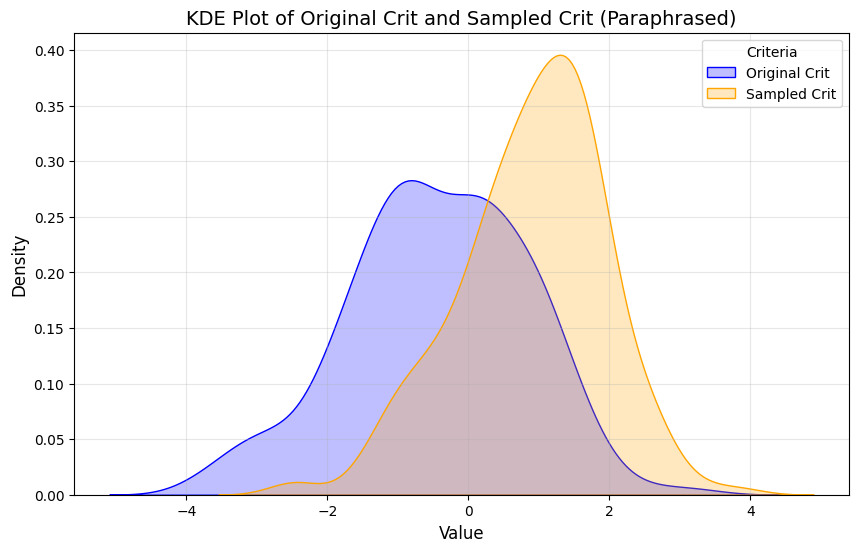

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# paraphrased 데이터만 필터링
df_paraphrased = df_combined[df_combined['type'] == 'paraphrased']

# KDE Plot 그리기
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')

# 플롯 꾸미기
plt.title('KDE Plot of Original Crit and Sampled Crit (Paraphrased)', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Criteria')
plt.grid(alpha=0.3)
plt.show()

<ipython-input-17-b83ed280eb57>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
<ipython-input-17-b83ed280eb57>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')


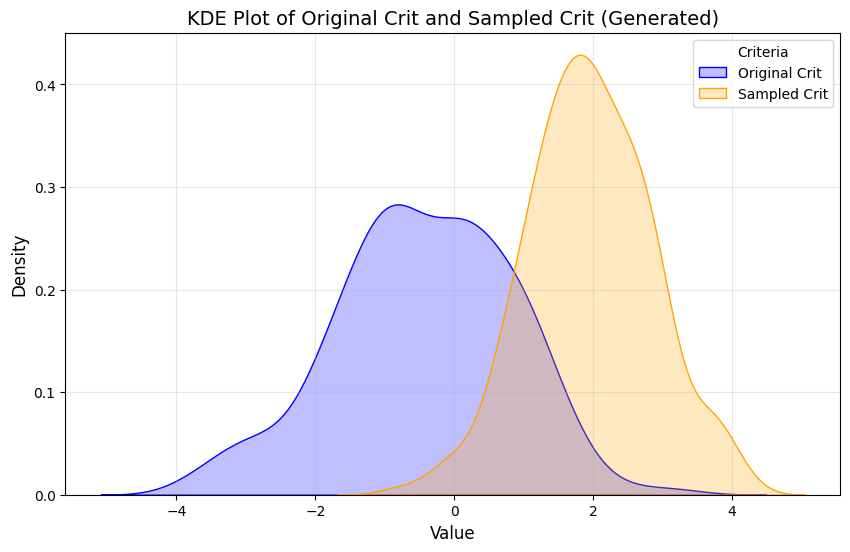

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# generated 데이터만 필터링
df_paraphrased = df_combined[df_combined['type'] == 'generated']

# KDE Plot 그리기
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')

# 플롯 꾸미기
plt.title('KDE Plot of Original Crit and Sampled Crit (Generated)', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Criteria')
plt.grid(alpha=0.3)
plt.show()

### 학년(수준)에 따른 kde plot

<ipython-input-18-0eb4454a7151>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
<ipython-input-18-0eb4454a7151>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')


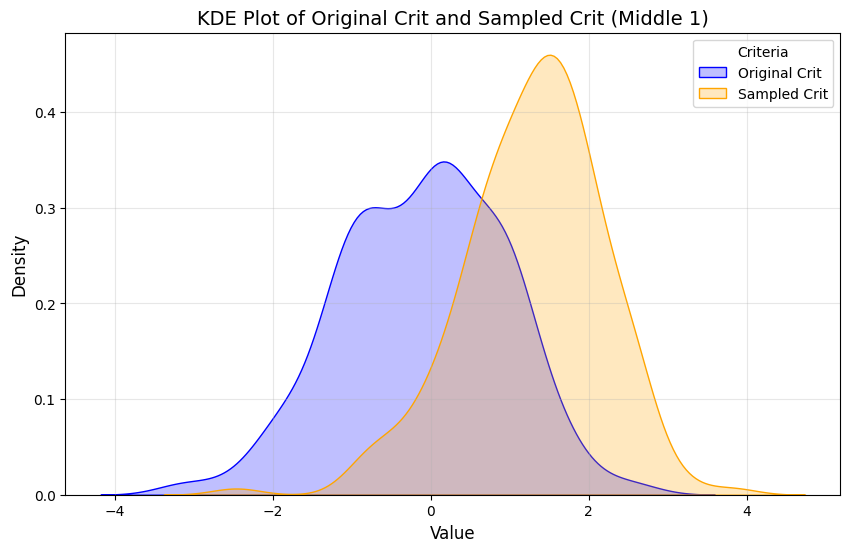

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# middle 1 필터링
df_paraphrased = df_combined[df_combined['grade'] == 'middle 1']

# KDE Plot 그리기
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')

# 플롯 꾸미기
plt.title('KDE Plot of Original Crit and Sampled Crit (Middle 1)', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Criteria')
plt.grid(alpha=0.3)
plt.show()

<ipython-input-19-5f7363136aa2>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
<ipython-input-19-5f7363136aa2>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')


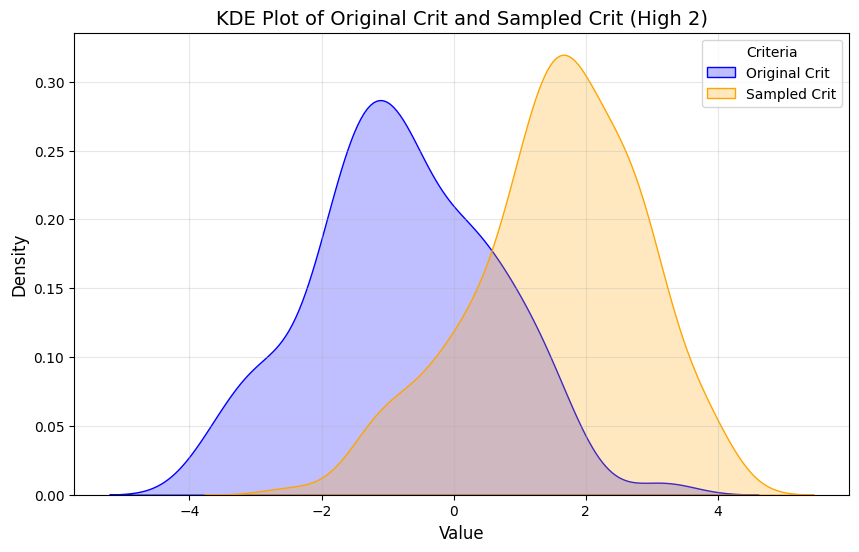

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# high 2 필터링
df_paraphrased = df_combined[df_combined['grade'] == 'high 2']

# KDE Plot 그리기
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df_paraphrased, x='original_crit', label='Original Crit', shade=True, color='blue')
sns.kdeplot(data=df_paraphrased, x='sampled_crit', label='Sampled Crit', shade=True, color='orange')

# 플롯 꾸미기
plt.title('KDE Plot of Original Crit and Sampled Crit (High 2)', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Criteria')
plt.grid(alpha=0.3)
plt.show()

### Box plot

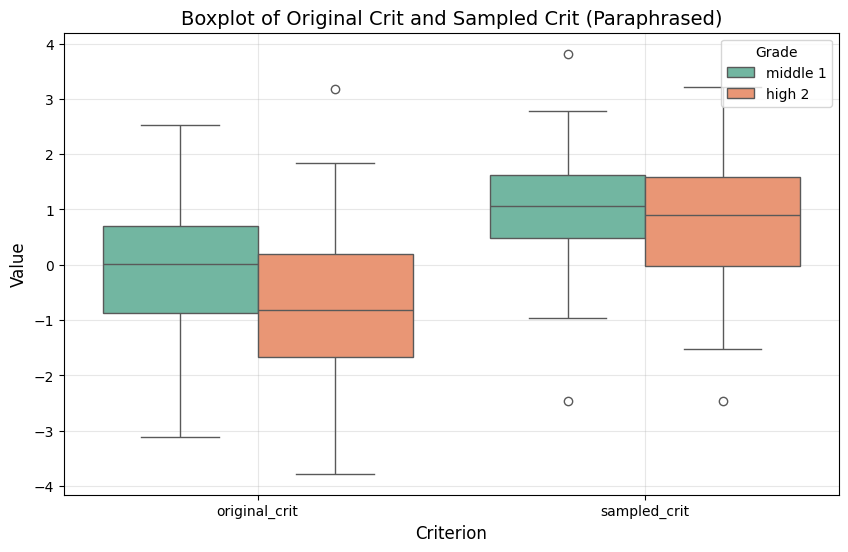

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# paraphrased 데이터만 필터링
df_paraphrased = df_combined[df_combined['type'] == 'paraphrased']

# Boxplot을 위한 데이터 준비
# "long format"으로 데이터를 변환
df_paraphrased_melted = df_paraphrased.melt(
    id_vars=['grade'],
    value_vars=['original_crit', 'sampled_crit'],
    var_name='Criterion',
    value_name='Value'
)

# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_paraphrased_melted, x='Criterion', y='Value', hue='grade', palette='Set2')

# 플롯 꾸미기
plt.title('Boxplot of Original Crit and Sampled Crit (Paraphrased)', fontsize=14)
plt.xlabel('Criterion', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Grade', loc='upper right')
plt.grid(alpha=0.3)
plt.show()

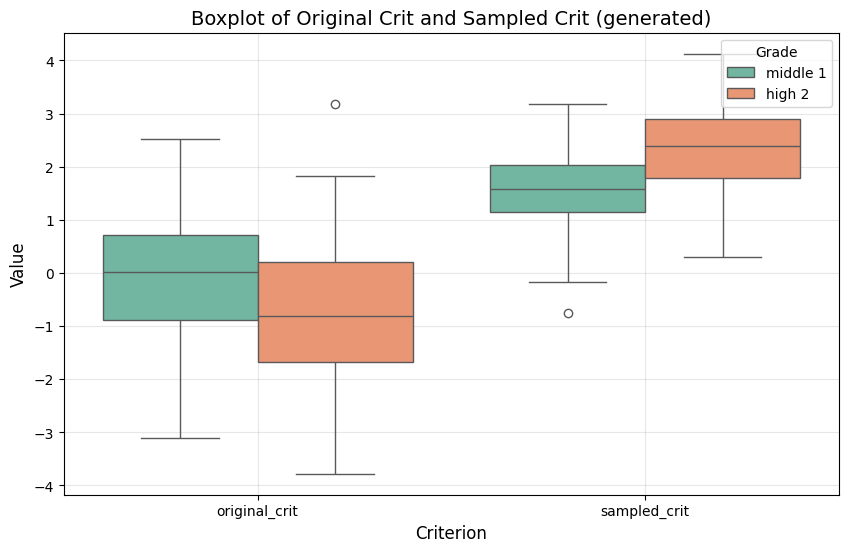

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# generated 데이터만 필터링
df_paraphrased = df_combined[df_combined['type'] == 'generated']

# Boxplot을 위한 데이터 준비
# "long format"으로 데이터를 변환
df_paraphrased_melted = df_paraphrased.melt(
    id_vars=['grade'],
    value_vars=['original_crit', 'sampled_crit'],
    var_name='Criterion',
    value_name='Value'
)

# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_paraphrased_melted, x='Criterion', y='Value', hue='grade', palette='Set2')

# 플롯 꾸미기
plt.title('Boxplot of Original Crit and Sampled Crit (generated)', fontsize=14)
plt.xlabel('Criterion', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Grade', loc='upper right')
plt.grid(alpha=0.3)
plt.show()

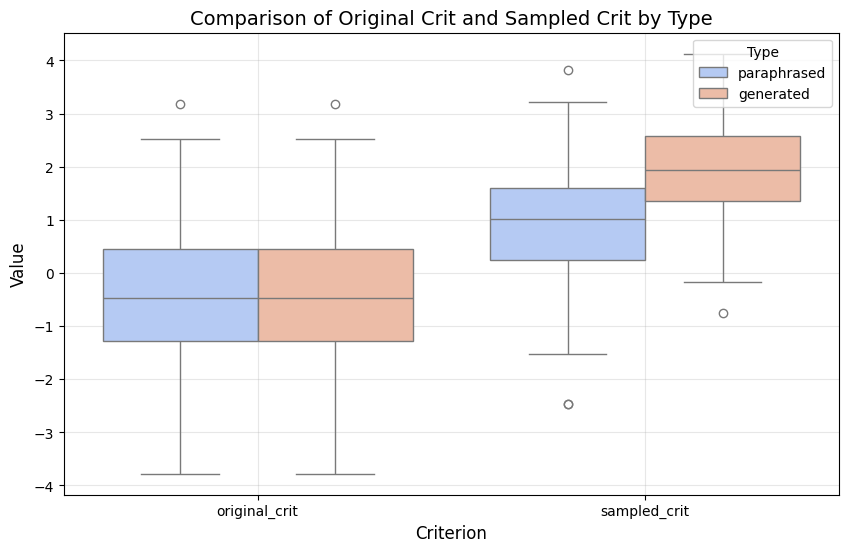

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot을 위한 데이터 준비
# "long format"으로 데이터를 변환
df_combined_melted = df_combined.melt(
    id_vars=['type'],
    value_vars=['original_crit', 'sampled_crit'],
    var_name='Criterion',
    value_name='Value'
)

# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined_melted, x='Criterion', y='Value', hue='type', palette='coolwarm')

# 플롯 꾸미기
plt.title('Comparison of Original Crit and Sampled Crit by Type', fontsize=14)
plt.xlabel('Criterion', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(title='Type', loc='upper right')
plt.grid(alpha=0.3)
plt.show()